In [1]:
import duckdb
import polars as pl
import pandas as pd

# Load the TSV file
file_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data\prescoringRaterModelOutput_3dim.tsv"

# Using Polars to load and analyze
df = pl.read_csv(file_path, separator='\t')

# Print the range of internalRaterFactor1
min_val = df['internalRaterFactor1'].min()
max_val = df['internalRaterFactor1'].max()

print(f"Range of internalRaterFactor1:")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")
print(f"Range: {max_val - min_val}")

Range of internalRaterFactor1:
Minimum: -1.5152386
Maximum: 0.83323216
Range: 2.34847076


In [2]:
# Categorize internalRaterFactor1 into ranges and get raterParticipantId lists
categories = {
    "less_than_neg1": df.filter(pl.col("internalRaterFactor1") < -1)["raterParticipantId"].to_list(),
    "neg1_to_neg0_5": df.filter((pl.col("internalRaterFactor1") >= -1) & (pl.col("internalRaterFactor1") < -0.5))["raterParticipantId"].to_list(),
    "neg0_5_to_0": df.filter((pl.col("internalRaterFactor1") >= -0.5) & (pl.col("internalRaterFactor1") < 0))["raterParticipantId"].to_list(),
    "0_to_0_5": df.filter((pl.col("internalRaterFactor1") >= 0) & (pl.col("internalRaterFactor1") < 0.5))["raterParticipantId"].to_list(),
    "more_than_0_5": df.filter(pl.col("internalRaterFactor1") >= 0.5)["raterParticipantId"].to_list()
}

# Print counts for each category
for category, ids in categories.items():
    print(f"{category}: {len(ids)} participants")

print("\nFirst few participants in each category:")
for category, ids in categories.items():
    print(f"{category}: {ids[:5] if len(ids) > 0 else 'None'}")

less_than_neg1: 1418 participants
neg1_to_neg0_5: 58689 participants
neg0_5_to_0: 110499 participants
0_to_0_5: 26538 participants
more_than_0_5: 267 participants

First few participants in each category:
less_than_neg1: ['00255BF71AC77463F5B0E0AC2B9AB0DA3DBD9C58E2E760B26848AB907F834100', '0107ED6102D9CC3EB102A131D28AD377F60CAFBA4D994AD3C379B27B71EF5173', '01206FA8A146088AF4F470EF4F229FA7ABB692C03F67FBCBB6B593846720BBEC', '0122AE2986B9C860C4F8DA171029577348FC864012059405DF48E6D21E85BF50', '012C8A33A49E279135119E29EAFA7D579B267A70CAB92F371522997FDD6791EF']
neg1_to_neg0_5: ['000045A5FA0CF004F68CBF2913506C37D540CF48522D33BFBF036AAC53FBDA8B', '0000AE9A69E1B5D132C053E253DC42A007EDE2F11C39CF89008F447F1ABF936F', '0001DD4CBED416F10FF5F2B3C4A1D7D61D91F2781E9E104202FF304ACEC80173', '000618D62D26469C059F4690178D06CB5483B122126D3223396C046F6B188E2D', '00074C96CF4724A61A380B64D2363B38EF8E343BAB17A396906C8D9DC9662E53']
neg0_5_to_0: ['0000315D36021A528D85155729DDBF2E299BB8C304087899EEDACE7782CE8272',

In [3]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# First, load the rater factor data and create categories
tsv_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data\prescoringRaterModelOutput_3dim.tsv"
rater_df = pl.read_csv(tsv_path, separator='\t')

# Create the 5 categories
categories = {
    "less_than_neg1": rater_df.filter(pl.col("internalRaterFactor1") < -1)["raterParticipantId"].to_list(),
    "neg1_to_neg0_5": rater_df.filter((pl.col("internalRaterFactor1") >= -1) & (pl.col("internalRaterFactor1") < -0.5))["raterParticipantId"].to_list(),
    "neg0_5_to_0": rater_df.filter((pl.col("internalRaterFactor1") >= -0.5) & (pl.col("internalRaterFactor1") < 0))["raterParticipantId"].to_list(),
    "0_to_0_5": rater_df.filter((pl.col("internalRaterFactor1") >= 0) & (pl.col("internalRaterFactor1") < 0.5))["raterParticipantId"].to_list(),
    "more_than_0_5": rater_df.filter(pl.col("internalRaterFactor1") >= 0.5)["raterParticipantId"].to_list()
}

print("Category sizes:")
for category, ids in categories.items():
    print(f"{category}: {len(ids)} participants")

Category sizes:
less_than_neg1: 1418 participants
neg1_to_neg0_5: 58689 participants
neg0_5_to_0: 110499 participants
0_to_0_5: 26538 participants
more_than_0_5: 267 participants


In [4]:
# Load the main dataset
parquet_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data\user_period_master_complete.parquet"
main_df = pl.read_parquet(parquet_path)

# Create datasets for each category
category_datasets = {}

for category_name, participant_ids in categories.items():
    if len(participant_ids) > 0:
        # Filter main dataset where userId is in the participant_ids list
        filtered_df = main_df.filter(pl.col("userId").is_in(participant_ids))
        
        # Group by period_start and calculate aggregates
        agg_df = filtered_df.group_by("period_start").agg([
            pl.col("total_notes_authored").sum().alias("total_notes_authored"),
            pl.col("total_ratings").sum().alias("total_ratings"),
            pl.col("helpful_ratio").mean().alias("avg_helpful_ratio"),
            pl.col("avg_core_note_intercept").mean().alias("avg_core_note_intercept"),
            pl.count().alias("user_count")
        ]).sort("period_start")
        
        category_datasets[category_name] = agg_df
        print(f"{category_name}: {len(filtered_df)} records, {len(agg_df)} time periods")
    else:
        print(f"{category_name}: No participants found")

print("\nDatasets created successfully!")

C:\Users\wongb\AppData\Local\Temp\ipykernel_1912\2527375000.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("user_count")


less_than_neg1: 66520 records, 72 time periods
neg1_to_neg0_5: 2092147 records, 72 time periods
neg1_to_neg0_5: 2092147 records, 72 time periods
neg0_5_to_0: 2957257 records, 72 time periods
neg0_5_to_0: 2957257 records, 72 time periods
0_to_0_5: 792235 records, 72 time periods
more_than_0_5: 11460 records, 72 time periods

Datasets created successfully!
0_to_0_5: 792235 records, 72 time periods
more_than_0_5: 11460 records, 72 time periods

Datasets created successfully!


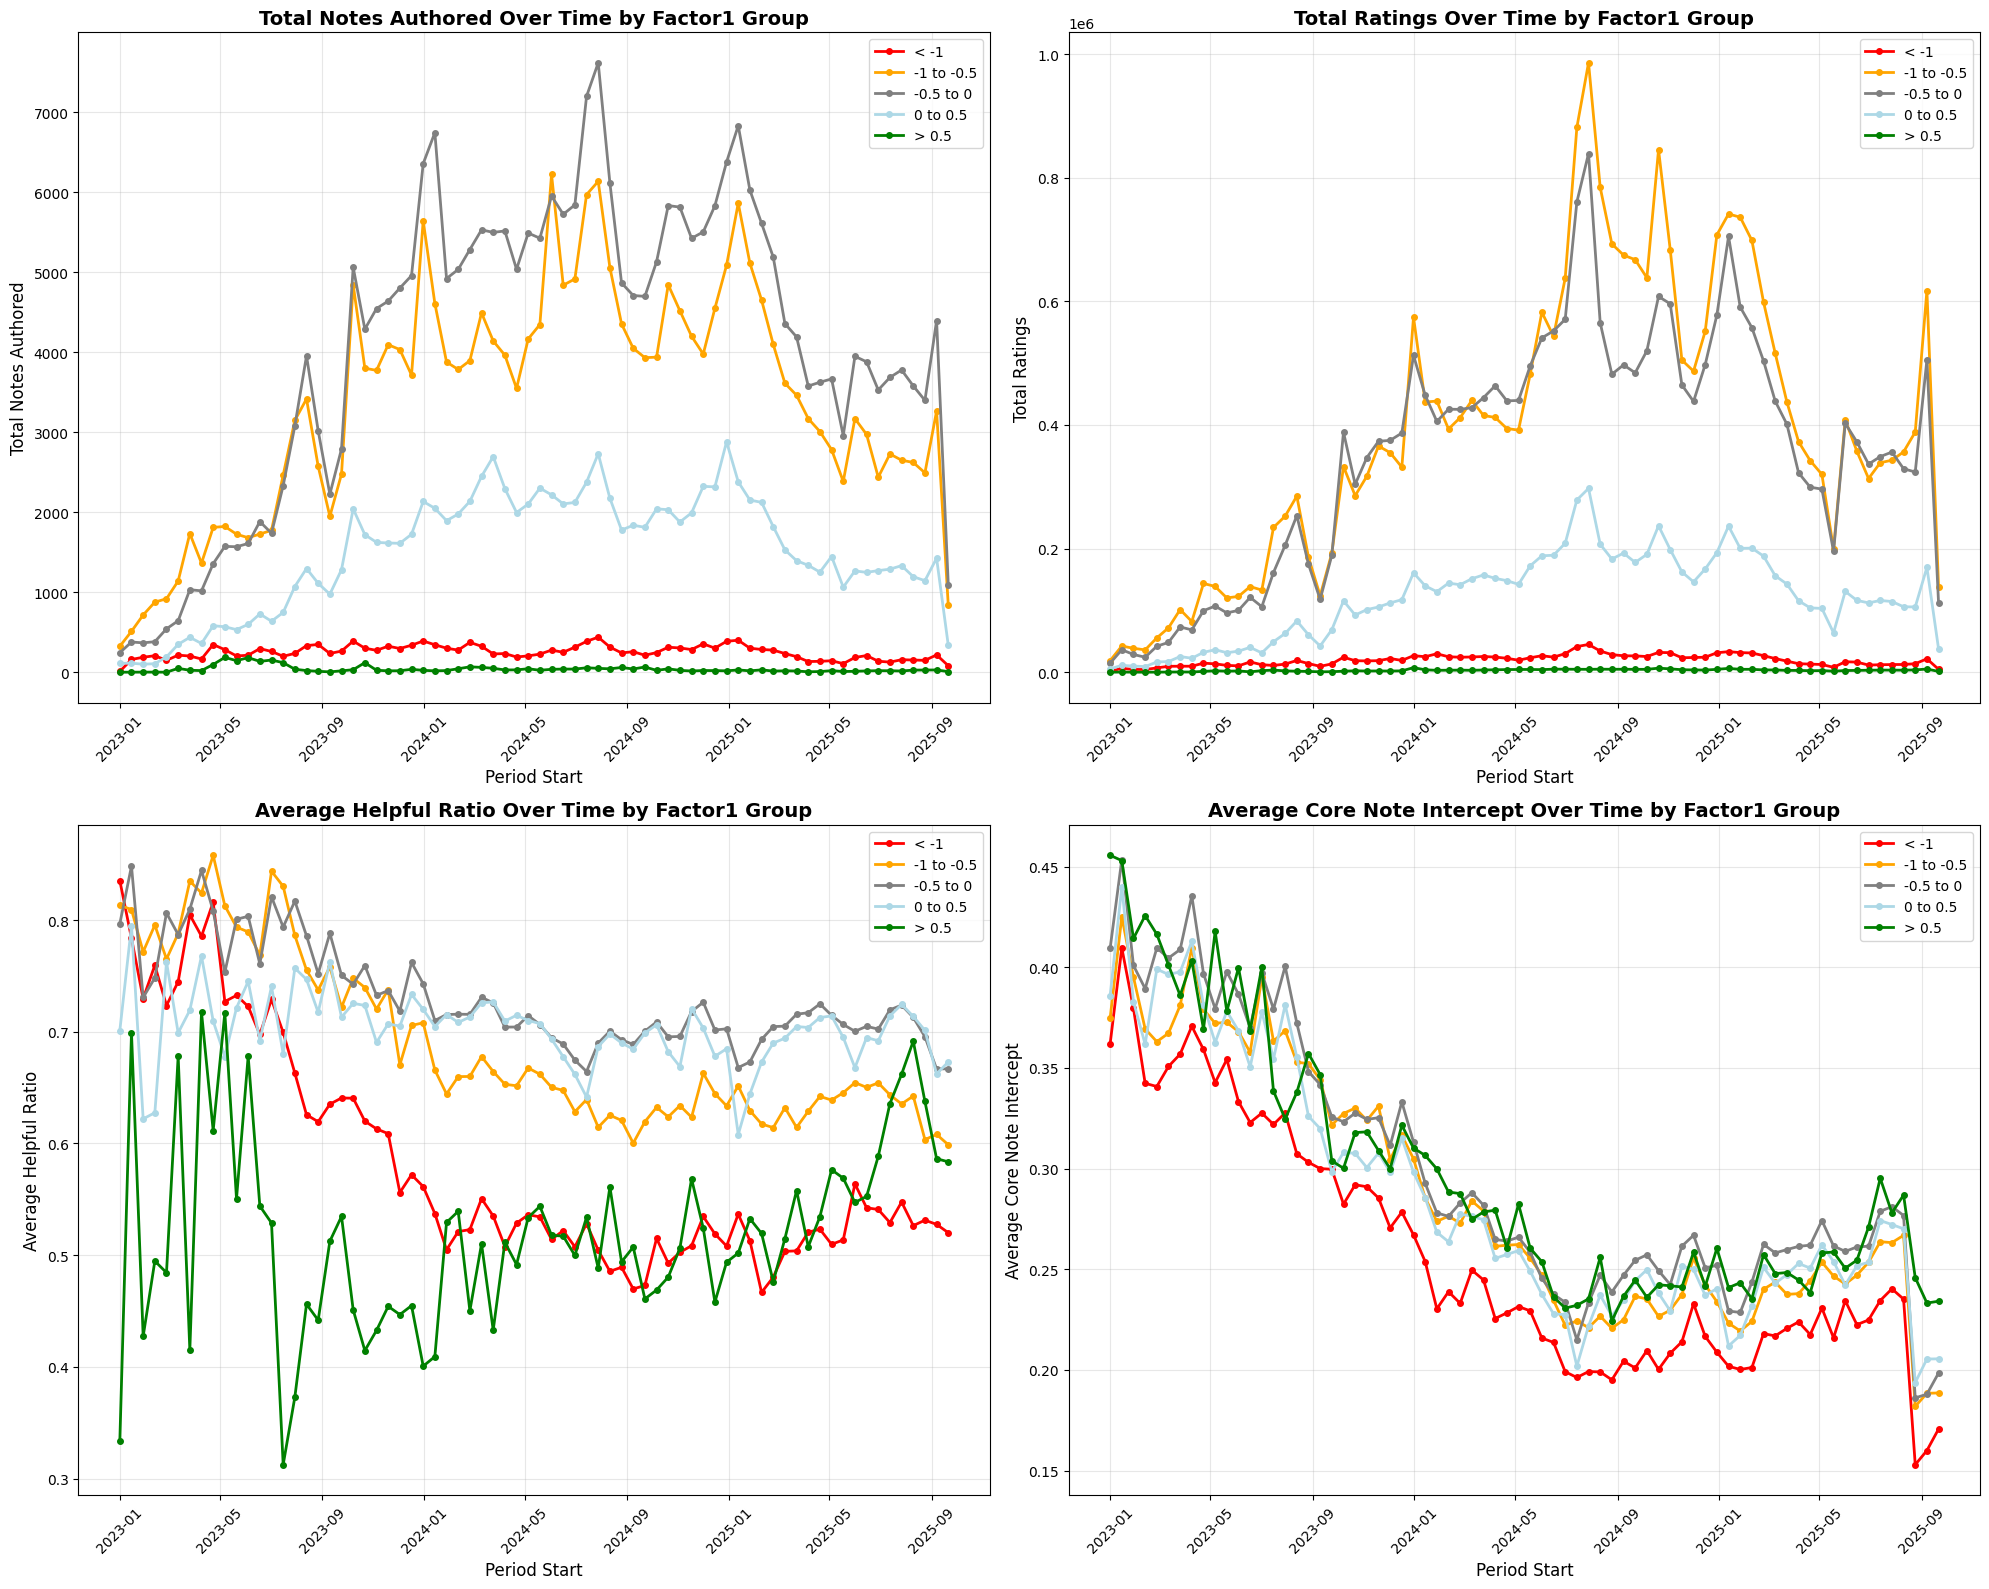

In [5]:
# Create time series visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
metrics = ['total_notes_authored', 'total_ratings', 'avg_helpful_ratio', 'avg_core_note_intercept']
metric_titles = ['Total Notes Authored', 'Total Ratings', 'Average Helpful Ratio', 'Average Core Note Intercept']

colors = ['red', 'orange', 'gray', 'lightblue', 'green']
category_labels = ['< -1', '-1 to -0.5', '-0.5 to 0', '0 to 0.5', '> 0.5']

for i, (metric, title) in enumerate(zip(metrics, metric_titles)):
    ax = axes[i//2, i%2]
    
    for j, (category_name, dataset) in enumerate(category_datasets.items()):
        if len(dataset) > 0:
            # Convert period_start to datetime for plotting
            pandas_df = dataset.to_pandas()
            pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
            
            ax.plot(pandas_df['period_start'], pandas_df[metric], 
                   color=colors[j], label=category_labels[j], linewidth=2, marker='o', markersize=4)
    
    ax.set_title(f'{title} Over Time by Factor1 Group', fontsize=14, fontweight='bold')
    ax.set_xlabel('Period Start', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [6]:
# Display summary statistics for each category in table format
print("Summary Statistics by Category")
print("=" * 120)

# Create a summary table
summary_data = []

for category_name, dataset in category_datasets.items():
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        
        # Calculate totals and averages across all periods
        total_notes = pandas_df['total_notes_authored'].sum()
        total_ratings = pandas_df['total_ratings'].sum()
        avg_helpful_ratio = pandas_df['avg_helpful_ratio'].mean()
        avg_intercept = pandas_df['avg_core_note_intercept'].mean()
        
        summary_data.append({
            'Factor1_Group': category_name.replace('_', ' ').title(),
            'Time_Periods': len(pandas_df),
            'Date_Range': f"{pandas_df['period_start'].min().strftime('%Y-%m-%d')} to {pandas_df['period_start'].max().strftime('%Y-%m-%d')}",
            'Total_Notes': f"{total_notes:,}",
            'Total_Ratings': f"{total_ratings:,}",
            'Avg_Helpful_Ratio': f"{avg_helpful_ratio:.3f}",
            'Avg_Core_Intercept': f"{avg_intercept:.3f}"
        })

# Create and display DataFrame
summary_df = pd.DataFrame(summary_data)

# Set pandas display options to show all data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(summary_df.to_string(index=False))

# Reset display options
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print("\n" + "=" * 120)

Summary Statistics by Category
 Factor1_Group  Time_Periods               Date_Range Total_Notes Total_Ratings Avg_Helpful_Ratio Avg_Core_Intercept
Less Than Neg1            72 2023-01-01 to 2025-09-21      17,986     1,407,395             0.582              0.257
Neg1 To Neg0 5            72 2023-01-01 to 2025-09-21     242,775    28,383,423             0.689              0.286
   Neg0 5 To 0            72 2023-01-01 to 2025-09-21     290,824    25,557,985             0.731              0.298
      0 To 0 5            72 2023-01-01 to 2025-09-21     107,859     8,706,584             0.702              0.286
 More Than 0 5            72 2023-01-01 to 2025-09-21       2,756       215,917             0.519              0.297



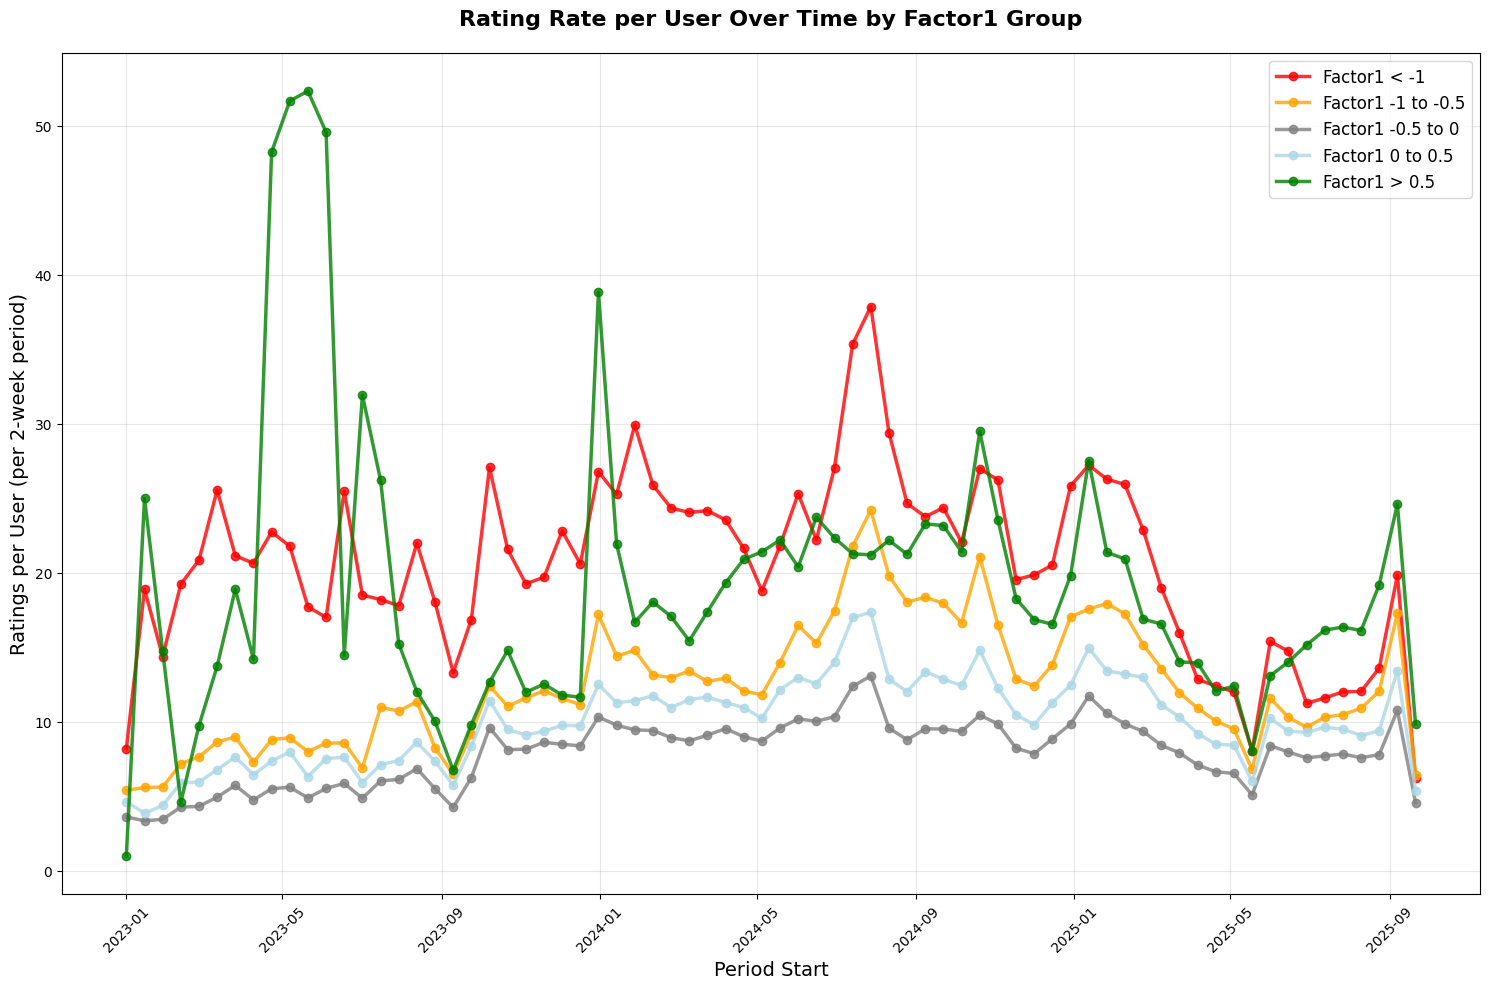


Rating Rate Summary Statistics:

Less Than Neg1:
  Average rating rate: 20.64 ratings/user/period
  Max rating rate: 37.88 ratings/user/period
  Min rating rate: 6.22 ratings/user/period

Neg1 To Neg0 5:
  Average rating rate: 12.39 ratings/user/period
  Max rating rate: 24.22 ratings/user/period
  Min rating rate: 5.39 ratings/user/period

Neg0 5 To 0:
  Average rating rate: 7.88 ratings/user/period
  Max rating rate: 13.08 ratings/user/period
  Min rating rate: 3.36 ratings/user/period

0 To 0 5:
  Average rating rate: 10.00 ratings/user/period
  Max rating rate: 17.35 ratings/user/period
  Min rating rate: 3.86 ratings/user/period

More Than 0 5:
  Average rating rate: 19.28 ratings/user/period
  Max rating rate: 52.34 ratings/user/period
  Min rating rate: 1.00 ratings/user/period



In [7]:
# Create rating rate visualization (total_ratings / number of users per period)
plt.figure(figsize=(15, 10))

colors = ['red', 'orange', 'gray', 'lightblue', 'green']
category_labels = ['< -1', '-1 to -0.5', '-0.5 to 0', '0 to 0.5', '> 0.5']

for j, (category_name, dataset) in enumerate(category_datasets.items()):
    if len(dataset) > 0:
        # Convert to pandas for easier manipulation
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        # Calculate rating rate (total_ratings / user_count)
        pandas_df['rating_rate'] = pandas_df['total_ratings'] / pandas_df['user_count']
        
        plt.plot(pandas_df['period_start'], pandas_df['rating_rate'], 
                color=colors[j], label=f'Factor1 {category_labels[j]}', 
                linewidth=2.5, marker='o', markersize=6, alpha=0.8)

plt.title('Rating Rate per User Over Time by Factor1 Group', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Period Start', fontsize=14)
plt.ylabel('Ratings per User (per 2-week period)', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics for rating rates
print("\nRating Rate Summary Statistics:\n")
for category_name, dataset in category_datasets.items():
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['rating_rate'] = pandas_df['total_ratings'] / pandas_df['user_count']
        
        print(f"{category_name.replace('_', ' ').title()}:")
        print(f"  Average rating rate: {pandas_df['rating_rate'].mean():.2f} ratings/user/period")
        print(f"  Max rating rate: {pandas_df['rating_rate'].max():.2f} ratings/user/period")
        print(f"  Min rating rate: {pandas_df['rating_rate'].min():.2f} ratings/user/period")
        print()

In [8]:
# Create datasets with misleading/not_misleading data for each category
category_misleading_datasets = {}

for category_name, participant_ids in categories.items():
    if len(participant_ids) > 0:
        # Filter main dataset where userId is in the participant_ids list
        filtered_df = main_df.filter(pl.col("userId").is_in(participant_ids))
        
        # Group by period_start and calculate aggregates including misleading counts
        agg_df = filtered_df.group_by("period_start").agg([
            pl.col("not_misleading_count").sum().alias("total_not_misleading"),
            pl.col("misleading_count").sum().alias("total_misleading"), 
            pl.col("total_notes_authored").sum().alias("total_notes_authored"),
            pl.count().alias("user_count")
        ]).sort("period_start")
        
        category_misleading_datasets[category_name] = agg_df
        print(f"{category_name}: {len(agg_df)} time periods with misleading data")

print("\nMisleading datasets created successfully!")

less_than_neg1: 72 time periods with misleading data


C:\Users\wongb\AppData\Local\Temp\ipykernel_1912\149365868.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("user_count")


neg1_to_neg0_5: 72 time periods with misleading data
neg0_5_to_0: 72 time periods with misleading data
neg0_5_to_0: 72 time periods with misleading data
0_to_0_5: 72 time periods with misleading data
more_than_0_5: 72 time periods with misleading data

Misleading datasets created successfully!
0_to_0_5: 72 time periods with misleading data
more_than_0_5: 72 time periods with misleading data

Misleading datasets created successfully!


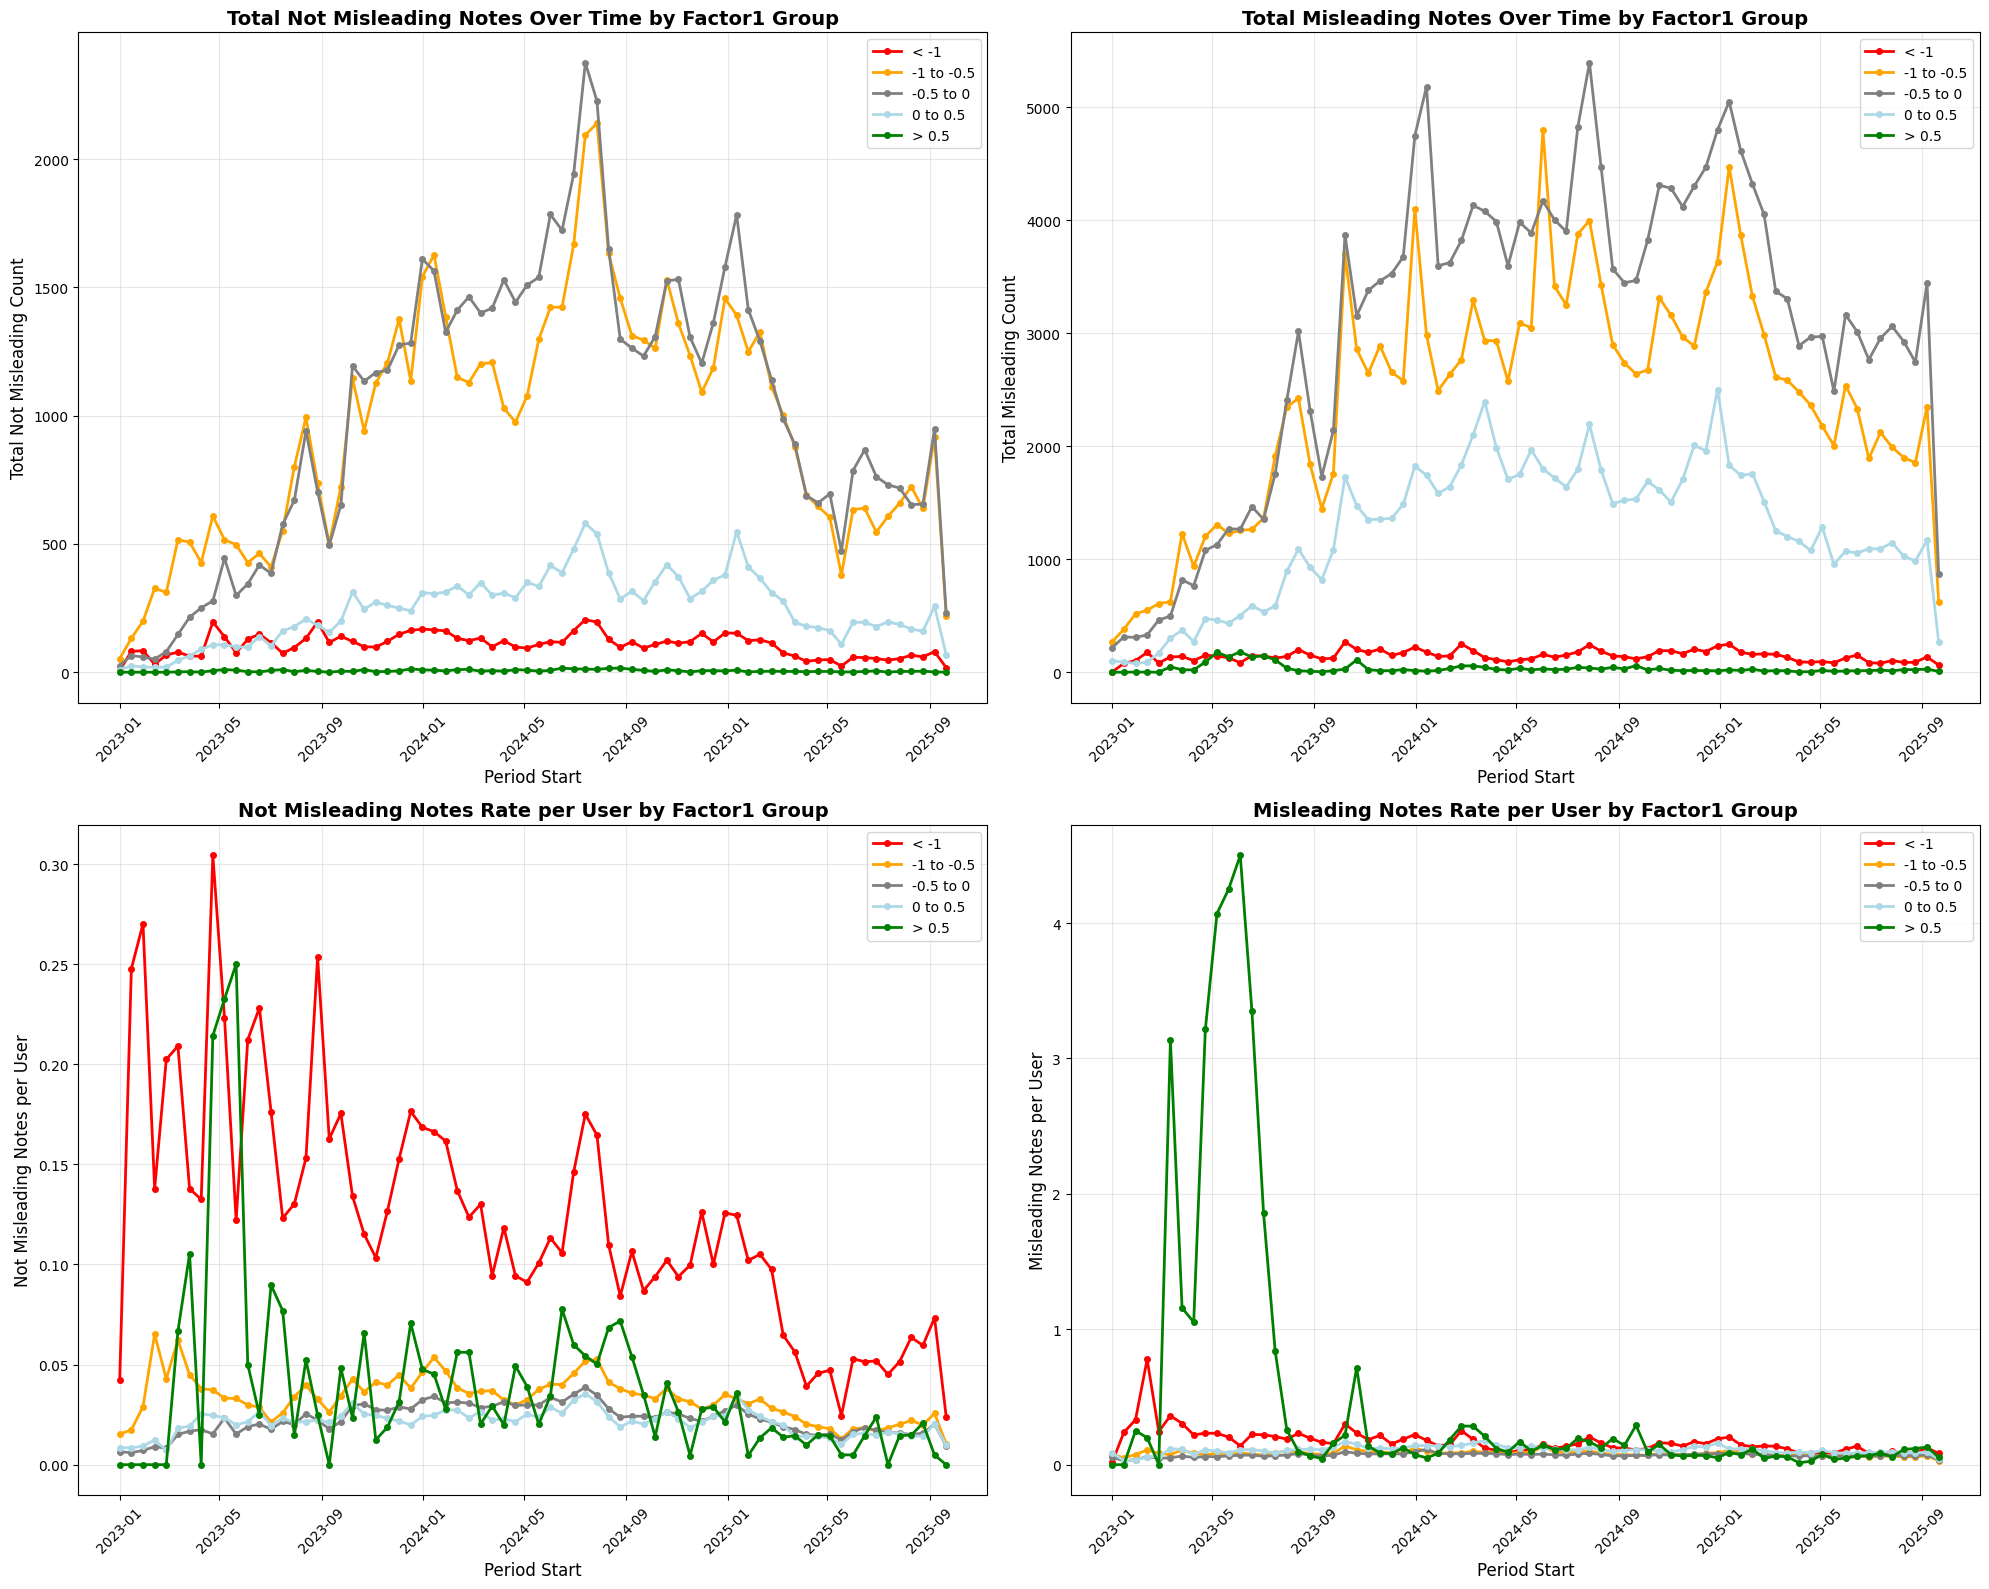

In [ ]:
# Create 4 graphs: not_misleading_count, misleading_count, and their respective rates
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

colors = ['red', 'orange', 'gray', 'lightblue', 'green']
category_labels = ['< -1', '-1 to -0.5', '-0.5 to 0', '0 to 0.5', '> 0.5']

# Graph 1: Total Not Misleading Count
ax1 = axes[0, 0]
for j, (category_name, dataset) in enumerate(category_misleading_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax1.plot(pandas_df['period_start'], pandas_df['total_not_misleading'], 
                color=colors[j], label=category_labels[j], linewidth=2, marker='o', markersize=4)

ax1.set_title('Total Not Misleading Notes Over Time by Factor1 Group', fontsize=14, fontweight='bold')
ax1.set_xlabel('Period Start', fontsize=12)
ax1.set_ylabel('Total Not Misleading Count', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Graph 2: Total Misleading Count
ax2 = axes[0, 1]
for j, (category_name, dataset) in enumerate(category_misleading_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax2.plot(pandas_df['period_start'], pandas_df['total_misleading'], 
                color=colors[j], label=categoryLabels[j], linewidth=2, marker='o', markersize=4)

ax2.set_title('Total Misleading Notes Over Time by Factor1 Group', fontsize=14, fontweight='bold')
ax2.set_xlabel('Period Start', fontsize=12)
ax2.set_ylabel('Total Misleading Count', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Graph 3: Not Misleading Rate per User
ax3 = axes[1, 0]
for j, (category_name, dataset) in enumerate(category_misleading_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['not_misleading_rate'] = pandas_df['total_not_misleading'] / pandas_df['user_count']
        
        ax3.plot(pandas_df['period_start'], pandas_df['not_misleading_rate'], 
                color=colors[j], label=category_labels[j], linewidth=2, marker='o', markersize=4)

ax3.set_title('Not Misleading Notes Rate per User by Factor1 Group', fontsize=14, fontweight='bold')
ax3.set_xlabel('Period Start', fontsize=12)
ax3.set_ylabel('Not Misleading Notes per User', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Graph 4: Misleading Rate per User
ax4 = axes[1, 1]
for j, (category_name, dataset) in enumerate(category_misleading_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['misleading_rate'] = pandas_df['total_misleading'] / pandas_df['user_count']
        
        ax4.plot(pandas_df['period_start'], pandas_df['misleading_rate'], 
                color=colors[j], label=category_labels[j], linewidth=2, marker='o', markersize=4)

ax4.set_title('Misleading Notes Rate per User by Factor1 Group', fontsize=14, fontweight='bold')
ax4.set_xlabel('Period Start', fontsize=12)
ax4.set_ylabel('Misleading Notes per User', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# Print summary statistics for misleading vs not misleading notes - formatted for better display
import pandas as pd

print("Misleading vs Not Misleading Summary Statistics")
print("=" * 80)

# Create a summary table instead of printing line by line
summary_data = []

for category_name, dataset in category_misleading_datasets.items():
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['not_misleading_rate'] = pandas_df['total_not_misleading'] / pandas_df['user_count']
        pandas_df['misleading_rate'] = pandas_df['total_misleading'] / pandas_df['user_count']
        
        total_not_misleading = pandas_df['total_not_misleading'].sum()
        total_misleading = pandas_df['total_misleading'].sum()
        avg_not_misleading_rate = pandas_df['not_misleading_rate'].mean()
        avg_misleading_rate = pandas_df['misleading_rate'].mean()
        
        # Calculate ratio
        ratio = total_not_misleading / total_misleading if total_misleading > 0 else 0
        
        summary_data.append({
            'Factor1_Group': category_name.replace('_', ' ').title(),
            'Total_Not_Misleading': f"{total_not_misleading:,}",
            'Total_Misleading': f"{total_misleading:,}",
            'Avg_NotMisleading_Rate': f"{avg_not_misleading_rate:.2f}",
            'Avg_Misleading_Rate': f"{avg_misleading_rate:.2f}",
            'NotMisleading:Misleading_Ratio': f"{ratio:.2f}:1"
        })

# Create and display DataFrame
summary_df = pd.DataFrame(summary_data)

# Set pandas display options to show all data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 25)

print(summary_df.to_string(index=False))

# Reset display options to default
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows') 
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print("\n" + "=" * 80)
print("Legend: Rate = notes per user per 2-week period")

Misleading vs Not Misleading Summary Statistics
 Factor1_Group Total_Not_Misleading Total_Misleading Avg_NotMisleading_Rate Avg_Misleading_Rate NotMisleading:Misleading_Ratio
Less Than Neg1              7,607.0         10,379.0                   0.12                0.17                         0.73:1
Neg1 To Neg0 5             68,667.0        174,108.0                   0.03                0.08                         0.39:1
   Neg0 5 To 0             72,211.0        218,613.0                   0.02                0.07                         0.33:1
      0 To 0 5             17,594.0         90,265.0                   0.02                0.11                         0.19:1
 More Than 0 5                373.0          2,383.0                   0.04                0.48                         0.16:1

Legend: Rate = notes per user per 2-week period


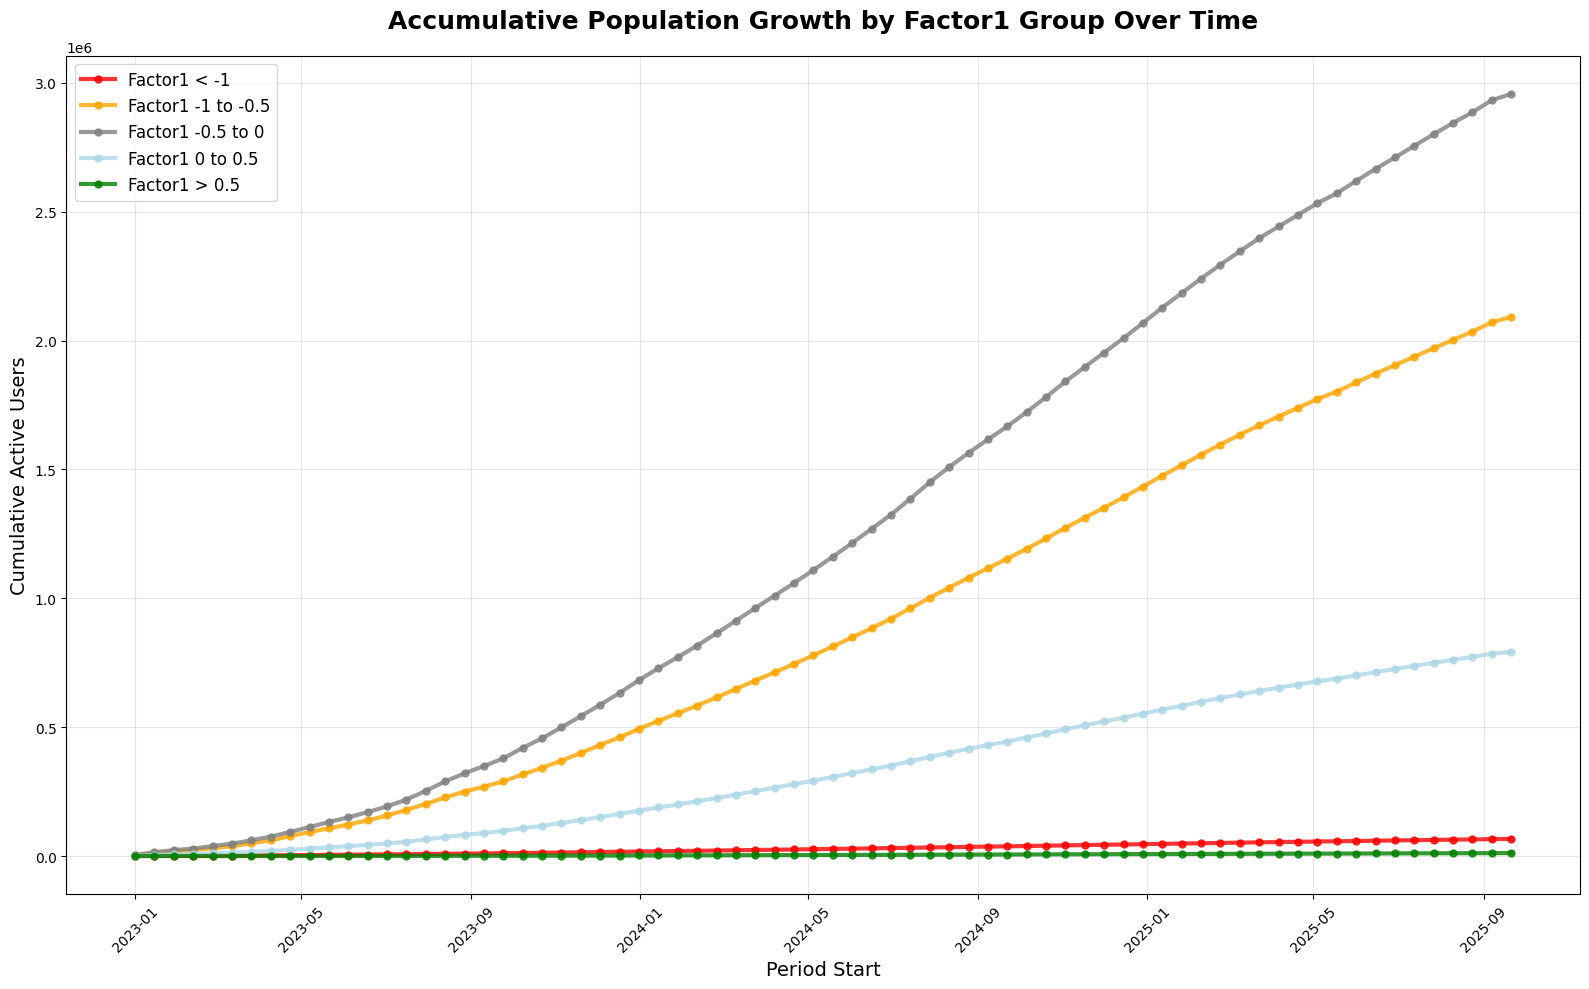

Accumulative Population Growth Summary
 Factor1_Group Initial_Users Final_Users Net_Growth Growth_Rate_%
Less Than Neg1           165      66,520     66,355      40215.2%
Neg1 To Neg0 5         3,475   2,092,147  2,088,672      60105.7%
   Neg0 5 To 0         4,039   2,957,257  2,953,218      73117.6%
      0 To 0 5         1,167     792,235    791,068      67786.5%
 More Than 0 5             3      11,460     11,457     381900.0%

Note: Cumulative users represents the running total of active users in each factor group per 2-week period


In [11]:
# Create accumulative population visualization over time
plt.figure(figsize=(16, 10))

colors = ['red', 'orange', 'gray', 'lightblue', 'green']
category_labels = ['< -1', '-1 to -0.5', '-0.5 to 0', '0 to 0.5', '> 0.5']

# Calculate cumulative user counts for each category
cumulative_data = {}

for j, (category_name, dataset) in enumerate(category_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df = pandas_df.sort_values('period_start')
        
        # Calculate cumulative sum of unique users appearing over time
        pandas_df['cumulative_users'] = pandas_df['user_count'].cumsum()
        cumulative_data[category_name] = pandas_df
        
        plt.plot(pandas_df['period_start'], pandas_df['cumulative_users'], 
                color=colors[j], label=f'Factor1 {category_labels[j]}', 
                linewidth=3, marker='o', markersize=5, alpha=0.8)

plt.title('Accumulative Population Growth by Factor1 Group Over Time', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Period Start', fontsize=14)
plt.ylabel('Cumulative Active Users', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final cumulative counts and growth statistics
print("Accumulative Population Growth Summary")
print("=" * 80)

summary_data = []
for category_name, data in cumulative_data.items():
    if len(data) > 0:
        initial_users = data['cumulative_users'].iloc[0]
        final_users = data['cumulative_users'].iloc[-1]
        growth = final_users - initial_users
        growth_rate = (growth / initial_users * 100) if initial_users > 0 else 0
        
        summary_data.append({
            'Factor1_Group': category_name.replace('_', ' ').title(),
            'Initial_Users': f"{initial_users:,}",
            'Final_Users': f"{final_users:,}",
            'Net_Growth': f"{growth:,}",
            'Growth_Rate_%': f"{growth_rate:.1f}%"
        })

growth_df = pd.DataFrame(summary_data)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(growth_df.to_string(index=False))

# Reset display options
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print("\n" + "=" * 80)
print("Note: Cumulative users represents the running total of active users in each factor group per 2-week period")

In [ ]:
# Create accumulative notes authored visualization over time
plt.figure(figsize=(16, 10))

colors = ['red', 'orange', 'gray', 'lightblue', 'green']
category_labels = ['< -1', '-1 to -0.5', '-0.5 to 0', '0 to 0.5', '> 0.5']

# Calculate cumulative notes authored for each category
cumulative_notes_data = {}

for j, (category_name, dataset) in enumerate(category_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df = pandas_df.sort_values('period_start')
        
        # Calculate cumulative sum of notes authored over time
        pandas_df['cumulative_notes'] = pandas_df['total_notes_authored'].cumsum()
        cumulative_notes_data[category_name] = pandas_df
        
        plt.plot(pandas_df['period_start'], pandas_df['cumulative_notes'], 
                color=colors[j], label=f'Factor1 {category_labels[j]}', 
                linewidth=3, marker='o', markersize=5, alpha=0.8)

plt.title('Accumulative Notes Authored by Factor1 Group Over Time', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Period Start', fontsize=14)
plt.ylabel('Cumulative Notes Authored', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final cumulative notes counts and productivity statistics
print("Accumulative Notes Authored Summary")
print("=" * 80)

summary_data = []
for category_name, data in cumulative_notes_data.items():
    if len(data) > 0:
        initial_notes = data['cumulative_notes'].iloc[0]
        final_notes = data['cumulative_notes'].iloc[-1]
        growth = final_notes - initial_notes
        growth_rate = (growth / initial_notes * 100) if initial_notes > 0 else 0
        avg_notes_per_period = data['total_notes_authored'].mean()
        
        summary_data.append({
            'Factor1_Group': category_name.replace('_', ' ').title(),
            'Initial_Notes': f"{initial_notes:,}",
            'Final_Notes': f"{final_notes:,}",
            'Net_Growth': f"{growth:,}",
            'Growth_Rate_%': f"{growth_rate:.1f}%",
            'Avg_Per_Period': f"{avg_notes_per_period:.1f}"
        })

notes_growth_df = pd.DataFrame(summary_data)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(notes_growth_df.to_string(index=False))

# Reset display options
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print("\n" + "=" * 80)
print("Note: Cumulative notes represents the running total of notes authored by each factor group per 2-week period")